# PHASM501 Project Part 2 & Part 3 Solution
### By Tejan Shah
### SN: 14004521

Before I begin, I realised I cannot upload the refined mesh vtk file to turnitin. Throughout the code I have refered to the refined mesh (refined to the first order) as lshape1.vtk. If you wish to test the mesh refinement, please rename the file to lshape1.vtk, or change the code where appropriate using whatever filename you gave it.

To begin I install pyopencl, mako and vtk. This is by far the longest process.

In [28]:
!conda install -y -c conda-forge pyopencl pocl
!conda install -y -c clinicalgraphics vtk

Solving environment: done

## Package Plan ##

  environment location: /home/nbuser/anaconda3_501

  added / updated specs: 
    - pocl
    - pyopencl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.5.1                |           py36_0         621 KB  conda-forge
    certifi-2018.4.16          |           py36_0         142 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         763 KB

The following packages will be UPDATED:

    certifi: 2018.4.16-py36_0  --> 2018.4.16-py36_0 conda-forge
    conda:   4.5.1-py36_0      --> 4.5.1-py36_0     conda-forge

The following packages will be DOWNGRADED:

    openssl: 1.0.2m-h26d622b_1 --> 1.0.2m-0         conda-forge


conda 4.5.1############################################################# | 100% 
certifi 2018.4.16######################################

Next I import all necessary python modules for mathematical manipulation, pyopencl and visualisation. Please note mako was installed as part of pyopencl. If the import for mako fails, restart the kernel and try again.

In [2]:
# Maths libraries
import numpy as np
import scipy.sparse.linalg as ssl
# Useful OpenCL libraries
import pyopencl as cl
import vtk
from mako.template import Template

# Useful visualisation libraries
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

I also make use of a class to measure the run time of the various solution implementations

In [3]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

Below is the (corrected) solution from part 1 of the project used to describe the grid mesh for which I will be solving.

In [4]:
class Grid(object):
    """A Grid class that can handle two dimensional flat and surface grids."""
    
    def __init__(self, vertices, elements, dtype='float64'):
        """
        Initialize a grid.
        
        Parameters
        ----------
        vertices: (N, 3) Array
            Vertices are stored in an (N, 3) array of floating point numbers.
        elements: (N, 3) Array
            Elements are stored in an (N, 3) array of type 'np.int32'.
        dtype: string
          dtype is either 'float64' or 'float32'. Internally, all structures and the
          vertices are converted to the format specified by 'dtype'. This is useful
          for OpenCL computations on GPUs that do not properly support double precision
          ('float64') types
        """

        self._vertices = vertices
        self._elements = elements
        self._dtype = dtype
        
        elements_np_array = self._elements
        vertices_np_array = self._vertices.astype(dtype)
        
        ocl_type = {'float32': 'float',
                    'float64': 'double'}[dtype]
        
        #make OpenCl context
        ctx = cl.create_some_context()
        queue = cl.CommandQueue(ctx)
        mf = cl.mem_flags
        
        #create input buffers
        elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements_np_array)
        vertices_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=vertices_np_array)
        
        #create output arrays
        corners_np_array = np.empty([len(elements),3,3]).astype(dtype)
        jacobian_np_array = np.empty([len(elements),3,3]).astype(dtype)
        determinant_np_array = np.empty([len(elements)]).astype(dtype)
        jacobianInverseTranspose_np_array = np.empty([len(elements),3,3]).astype(dtype)
        normals_np_array = np.empty([len(elements),3]).astype(dtype)
        
        #make output buffers based on output arrays
        corners_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,corners_np_array.nbytes)
        jacobian_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,jacobian_np_array.nbytes)
        determinant_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,determinant_np_array.nbytes)
        jacobianInverseTranspose_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,jacobianInverseTranspose_np_array.nbytes)
        normals_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,normals_np_array.nbytes)

        kernel = """
            inline float float_one()
            {
                return 1.0f;
            }

            inline double double_one()
            {
                return 1.0;

            }
        
        
            __kernel void FiniteElement(const __global int* elements_buffer,
                                        const __global ${realtype} *vertices_buffer,
                                        __global ${realtype} *corners_buffer,
                                        __global ${realtype} *jacobian_buffer,
                                        __global ${realtype} *determinant_buffer,
                                        __global ${realtype} *jacobianInverseTranspose_buffer,
                                        __global ${realtype} *normals_buffer){

            const int gid = get_global_id(0);
            
            int e1 = elements_buffer[2*(3*gid)];
            int e2 = elements_buffer[2*(3*gid+1)];
            int e3 = elements_buffer[2*(3*gid+2)];

            //v0: First corner of element
            corners_buffer[gid*9] = vertices_buffer[e1*3];
            corners_buffer[gid*9+1] = vertices_buffer[e1*3 +1];
            corners_buffer[gid*9+2] = vertices_buffer[e1*3 +2];
            
            //v1: Second corner of element
            corners_buffer[gid*9+3] = vertices_buffer[e2*3];
            corners_buffer[gid*9+4] = vertices_buffer[e2*3 +1]; 
            corners_buffer[gid*9+5] = vertices_buffer[e2*3 +2]; 
            
            //v2: Third corner of element
            corners_buffer[gid*9+6] = vertices_buffer[e3*3]; 
            corners_buffer[gid*9+7]= vertices_buffer[e3*3 + 1]; 
            corners_buffer[gid*9+8] = vertices_buffer[e3*3 + 2]; 
            
            //v1-v0: First column of Jacobian
            jacobian_buffer[gid*9] = corners_buffer[gid*9+3] - corners_buffer[gid*9];
            jacobian_buffer[gid*9+3] = corners_buffer[gid*9+4] - corners_buffer[gid*9+1];
            jacobian_buffer[gid*9+6] = corners_buffer[gid*9+5] - corners_buffer[gid*9+2];
            
            //v2-v0: Second column of Jacobian
            jacobian_buffer[gid*9+1] = corners_buffer[gid*9+6] - corners_buffer[gid*9];
            jacobian_buffer[gid*9+4] = corners_buffer[gid*9+7] - corners_buffer[gid*9+1];
            jacobian_buffer[gid*9+7] = corners_buffer[gid*9+8] - corners_buffer[gid*9+2];
            
            //v2-v0: Second column of Jacobian
            jacobian_buffer[gid*9+2] = 0;
            jacobian_buffer[gid*9+5] = 0;
            jacobian_buffer[gid*9+8] = 0;

            
            //determinant_buffererminant of Jacobian Matrix
            determinant_buffer[gid] = jacobian_buffer[gid*9]*jacobian_buffer[gid*9+4] 
            - jacobian_buffer[gid*9+1]*jacobian_buffer[gid*9+3];
            
            //Inverse Transpose of Jacobian
            ${realtype} inv = (${realtype}_one()/determinant_buffer[gid]);
            jacobianInverseTranspose_buffer[gid*9] = inv*jacobian_buffer[gid*9+4];
            jacobianInverseTranspose_buffer[gid*9+1] = -1*inv*jacobian_buffer[gid*9+3];
            jacobianInverseTranspose_buffer[gid*9+2] = 0;
            jacobianInverseTranspose_buffer[gid*9+3] = -1*inv*jacobian_buffer[gid*9+1];
            jacobianInverseTranspose_buffer[gid*9+4] = inv*jacobian_buffer[gid*9];
            jacobianInverseTranspose_buffer[gid*9+5] = 0;
            jacobianInverseTranspose_buffer[gid*9+6] = 0;
            jacobianInverseTranspose_buffer[gid*9+7] = 0;
            jacobianInverseTranspose_buffer[gid*9+8] = 0;
            
            ${realtype} abs = (determinant_buffer[gid]*determinant_buffer[gid])/determinant_buffer[gid];
            normals_buffer[gid*3] = 0;
            normals_buffer[gid*3+1] = 0;
            normals_buffer[gid*3+2] = determinant_buffer[gid]/abs;
            
            }
            """
        #build kernel
        code = Template(kernel).render(realtype=ocl_type)
        prg = cl.Program(ctx,code).build()
        FE = prg.FiniteElement
        #run and time program
        with Timer() as t:
            FE(queue, corners_np_array.shape,None,elements_buffer,vertices_buffer,corners_buffer,
               jacobian_buffer,determinant_buffer,jacobianInverseTranspose_buffer,normals_buffer)
            #copy results from output buffers to appropriate arrays
            cl.enqueue_copy(queue,corners_np_array,corners_buffer)
            self._corners = corners_np_array
            cl.enqueue_copy(queue,jacobian_np_array,jacobian_buffer)
            self._jacobian = jacobian_np_array
            cl.enqueue_copy(queue,determinant_np_array,determinant_buffer)
            self._determinant = determinant_np_array
            cl.enqueue_copy(queue,jacobianInverseTranspose_np_array,jacobianInverseTranspose_buffer)
            self._jacobianInverseTranspose = jacobianInverseTranspose_np_array
            cl.enqueue_copy(queue,normals_np_array,normals_buffer)
            self._normal = normals_np_array
        
            print("Corners:\n\n",corners_np_array,"\n\n Jacobians:\n\n",jacobian_np_array,
                  "\n\ndeterminants:\n\n",determinant_np_array,
                  "\n\n Inverse Transposes:\n\n",jacobianInverseTranspose_np_array
                 ,"\n\nNormal:\n\n",normals_np_array)
        print("Time: ",t.interval)
    
    @property
    def vertices(self):
        """Return the vertices."""
        return self._vertices
        
    @property
    def elements(self):
        """Return the elemenets."""
        return self._elements
    
    def corners(self, element_index):
        """Return the corners of a given element as (3, 3) array"""
        return self._corners[element_index]
    
    
    def integration_element(self, element_index):
        """Return |determinant_buffer J| for a given element."""

        return self._determinant[element_index]
    
    def normal(self, element_index):
        """Return the exterior pointing normal of an element."""
        return self._normal
    
    def inverse_jacobian_transpose(self, element_index):
        """Return the (3, 3) inverse Jacobian transpose of an element."""
        return self._jacobianInverseTranspose[element_index]
    
    
    @classmethod
    def from_file(cls, file_name,dtype='float64'):
        """Read a mesh from a vtk file."""
        reader = vtk.vtkUnstructuredGridReader()
        reader.SetFileName(file_name)
        reader.Update()
        
        data = reader.GetOutput()
    
        points = []
        for i in range(data.GetNumberOfPoints()):
            points.append(list(data.GetPoint(i)))
        
        points = np.array(points)

        cells =[]
        for i in range(data.GetNumberOfCells()):
            cell = []
            if(data.GetCell(i).GetNumberOfPoints() != 3):
                continue
            cell.append(data.GetCell(i).GetPointId(0))
            cell.append(data.GetCell(i).GetPointId(1))
            cell.append(data.GetCell(i).GetPointId(2))
            cells.append(cell)
        cells=np.array(cells)
        
        grid = Grid(points,cells,dtype)
        return grid

I instantiate a Grid object representing the mesh in question. As many of the later functions will be depended on the number of vertices and number of elements on the grid, I set them as global variables to be reused throughout the solution. The same is done with the local-to-global map, elements.

In [5]:
dtype='float64'
grid = Grid.from_file('lshape.vtk',dtype=dtype)

num_elements = len(grid.elements)
num_vertices = len(grid.vertices)
elements=grid.elements

Corners:

 [[[ 1.       1.       0.     ]
  [ 0.96875  0.96875  0.     ]
  [ 1.       0.9375   0.     ]]

 [[ 0.96875  0.96875  0.     ]
  [ 0.96875  0.90625  0.     ]
  [ 1.       0.9375   0.     ]]

 [[ 0.96875  0.96875  0.     ]
  [ 0.9375   0.9375   0.     ]
  [ 0.96875  0.90625  0.     ]]

 ...

 [[ 0.5625  -0.5      0.     ]
  [ 0.53125 -0.46875  0.     ]
  [ 0.53125 -0.53125  0.     ]]

 [[ 0.5625  -0.5      0.     ]
  [ 0.5625  -0.4375   0.     ]
  [ 0.53125 -0.46875  0.     ]]

 [[ 0.53125 -0.53125  0.     ]
  [ 0.53125 -0.46875  0.     ]
  [ 0.5     -0.5      0.     ]]] 

 Jacobians:

 [[[-0.03125  0.       0.     ]
  [-0.03125 -0.0625   0.     ]
  [ 0.       0.       0.     ]]

 [[ 0.       0.03125  0.     ]
  [-0.0625  -0.03125  0.     ]
  [ 0.       0.       0.     ]]

 [[-0.03125  0.       0.     ]
  [-0.03125 -0.0625   0.     ]
  [ 0.       0.       0.     ]]

 ...

 [[-0.03125 -0.03125  0.     ]
  [ 0.03125 -0.03125  0.     ]
  [ 0.       0.       0.     ]]

 [[ 0.     

# Part 2

I generate an array that, when multiplied with an array of nodal values, will set any boundary nodes to 0 as per the boundary condition. Interestingly, in the VTK file provided, the first 128 nodes are on the boundary; this provides a slightly simpler, albeit less general, test for the boundary. The boundary condition below is specific for the L shaped mesh, and so the function would need to be modified for any other sized/shaped mesh.

In [6]:
#get precision of machine based on datatype
if grid._dtype == 'float64':
    precision = np.finfo(float).eps
elif grid._dtype == 'float32':
    precision = np.finfo(np.float32).eps
def test_boundaries(grid):

        
    #we break up the L shape grid into two rectangular segments, and test the boundaries of the segments

    boundary = np.zeros(num_vertices)
    for i in range(num_vertices):
        x = grid.vertices[i][0]
        y = grid.vertices[i][1]
        horizontal = ( precision < x < 1-precision) and (-1+precision < y < precision)
        verticle = (-1+precision < x <1-precision) and (precision < y < 1-precision)
        boundary[i] = horizontal or verticle

    return boundary

boundary = test_boundaries(grid)


The method implemented requires the local y contributions being calculated in one kernel, while a second is used to assemble the global y vector.

The cell below shows my first attempt for the assembly kernel. This assembly kernel made use of an assembly matrix. This matrix is a $N*3M$ matrix, where $N$ is the number of vertices and $M$ is the number of elements. Each row of this matrix corresponds to the elements that are to be summed into a given element of $\bf y$. As such, each element of a row is 0, except for those that correspond to elements of $\vec{y}$ that are to be summed into the corresponding element of $\bf y$. It turns out that the same matrix can be reused when assembling the vector $\bf b$, as well as the soltuions in part 3. Since the matrix is made from the local to global map, which is unchanging for a given grid, we can build the assembly matrix once and run it as many times as required. When testing this method however, I found that it was both twice as slow as a python alternative and took up lots of memory. As such an alternative method was used in the rest of the code.

In [7]:
"""
def assemblyMatrix(dtype):
    assembly_matrix = np.zeros((num_vertices,num_elements*3)).astype(dtype)
    for i in range(num_elements):
        assembly_matrix[elements[i][0]][3*i]=1
        assembly_matrix[elements[i][1]][3*i+1]=1
        assembly_matrix[elements[i][2]][3*i+2]=1
    return assembly_matrix
assembly_matrix = assemblyMatrix(dtype)
"""

kernel = """
        
        inline float float_zero()
            {
                return 0.0f;
            }

            inline double double_zero()
            {
                return 0.0;

            }

        __kernel void local_y(const __global int* elements,
                                        const __global ${realtype} *x,
                                        const __global ${realtype} *determinant,
                                        const __global ${realtype} *jIT,
                                            __global ${realtype} *y_vector){
        int gid = get_global_id(0);//element id
        
        //use global to local index map
        int e1 = elements[2*(3*gid)];
        int e2 = elements[2*(3*gid+1)];
        int e3 = elements[2*(3*gid+2)];
        
        //calculate local x vector
        ${realtype} localx[3];
        localx[0] = x[e1];
        localx[1] = x[e2]; 
        localx[2] = x[e3];
        
        //gradient of the hat functions on reference element
        ${realtype} hat1[2] = {-1,-1};

        ${realtype} hat2[2] = {1,0};
        
        ${realtype} hat3[2] = {0,1};
        
        //translate reference element hat functions to grid element basis functions using jacobian inverse transpose
        ${realtype} psi1[2];
        psi1[0] = jIT[9*gid]*hat1[0] + jIT[9*gid+1]*hat1[1];
        psi1[1] = jIT[9*gid+3]*hat1[0] + jIT[9*gid+4]*hat1[1];
        
        
        ${realtype} psi2[2];
        psi2[0] = jIT[9*gid]*hat2[0] + jIT[9*gid+1]*hat2[1];
        psi2[1] = jIT[9*gid+3]*hat2[0] + jIT[9*gid+4]*hat2[1];
       
        
        ${realtype} psi3[2];
        psi3[0] = jIT[9*gid]*hat3[0] + jIT[9*gid+1]*hat3[1];
        psi3[1] = jIT[9*gid+3]*hat3[0] + jIT[9*gid+4]*hat3[1];
        
        
        //Assemble local matrix A
        
        ${realtype} A[9];
        ${realtype} det = determinant[gid];
        
        A[0] = 0.5*(psi1[0]*psi1[0] + psi1[1]*psi1[1])*det;
        A[1] = 0.5*(psi1[0]*psi2[0] + psi1[1]*psi2[1])*det;
        A[2] = 0.5*(psi1[0]*psi3[0] + psi1[1]*psi3[1])*det;
        
        A[3] = 0.5*(psi2[0]*psi1[0] + psi2[1]*psi1[1])*det;
        A[4] = 0.5*(psi2[0]*psi2[0] + psi2[1]*psi2[1])*det;
        A[5] = 0.5*(psi2[0]*psi3[0] + psi2[1]*psi3[1])*det;
        
        A[6] = 0.5*(psi3[0]*psi1[0] + psi3[1]*psi1[1])*det;
        A[7] = 0.5*(psi3[0]*psi2[0] + psi3[1]*psi2[1])*det;
        A[8] = 0.5*(psi3[0]*psi3[0] + psi3[1]*psi3[1])*det;
    
        //Calculate local y vector
        
        ${realtype} localy[3];
        
        y_vector[3*gid] = A[0]*localx[0] + A[1]*localx[1] + A[2]*localx[2];
        y_vector[3*gid+1] = A[3]*localx[0] + A[4]*localx[1] + A[5]*localx[2];
        y_vector[3*gid+2] = A[6]*localx[0] + A[7]*localx[1] + A[8]*localx[2];

        }
        
        __kernel void Assemble_y(const int num_elements,
                                    const __global ${realtype} *y_vector,
                                        const __global ${realtype} *assembly,
                                            __global ${realtype} *y){
                                            
                                            
        int gid = get_global_id(0);//vertices id
        
        ${realtype} acc = ${realtype}_zero();
        
        for(int i = 0; i < 3*num_elements;i++){
            acc += assembly[gid*3*num_elements + i]*y_vector[i];
        }
        
        y[gid]=acc;
        
        }
"""
"""

#An assembly matrix for converting the array of local y vectors into the global y vector.
#This can be reused throughout the code.


def python_Y_assembly(y_vector):
    y = np.zeros(num_vertices).astype(dtype)

    for i in range(num_elements):
        y[elements[i][0]]+=y_vector[i][0]
        y[elements[i][1]]+=y_vector[i][1]
        y[elements[i][2]]+=y_vector[i][2]

    y=y*boundary
    
    return y

def openCL_Y_assembly(y_vector):
    
    ocl_type = {'float32': 'float',
                    'float64': 'double'}[dtype]
    code = Template(kernel).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    assemble_y = prg.Assemble_y

    
    y_vector_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_vector)
    assembly_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=assembly_matrix)

    y = np.zeros(num_vertices).astype(dtype)
    y_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y.nbytes)
    
    
    assemble_y(queue,(num_vertices,),None,np.int32(num_elements),y_vector_buffer,assembly_buffer,y_buffer)

    cl.enqueue_copy(queue,y,y_buffer)

    y=y*boundary
    return y

def mv(x):
    ocl_type = {'float32': 'float',
                    'float64': 'double'}[dtype]
        
    #make OpenCl context
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags

    #create input buffers
    e = grid.elements
    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=e)
    x=(x*boundary).astype(dtype)
    x_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x)

    determinant = grid._determinant.astype(dtype)
    det_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf = determinant)

    jacobianInverseTranspose = grid._jacobianInverseTranspose.astype(dtype)
    jacobianInverseTranspose_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                                hostbuf = jacobianInverseTranspose)

    #create output buffer
    y_vector = np.zeros((num_elements,3)).astype(dtype)
    y_vector_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y_vector.nbytes)


    code = Template(kernel).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    local_y = prg.local_y

    local_y(queue,(num_elements,),None,elements_buffer,x_buffer,det_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
    cl.enqueue_copy(queue,y_vector,y_vector_buffer)
    
    with Timer() as t:
        y=python_Y_assembly(y_vector.astype(dtype))
    #print("Python Execution Time: ",t.interval,"s")

    with Timer() as t:
        y=openCL_Y_assembly(y_vector.astype(dtype))
    #print("OpenCL Execution Time: ",t.interval,"s")
    return y
"""

'\n\n#An assembly matrix for converting the array of local y vectors into the global y vector.\n#This can be reused throughout the code.\n\n\ndef python_Y_assembly(y_vector):\n    y = np.zeros(num_vertices).astype(dtype)\n\n    for i in range(num_elements):\n        y[elements[i][0]]+=y_vector[i][0]\n        y[elements[i][1]]+=y_vector[i][1]\n        y[elements[i][2]]+=y_vector[i][2]\n\n    y=y*boundary\n    \n    return y\n\ndef openCL_Y_assembly(y_vector):\n    \n    ocl_type = {\'float32\': \'float\',\n                    \'float64\': \'double\'}[dtype]\n    code = Template(kernel).render(realtype=ocl_type)\n    prg = cl.Program(ctx,code).build()\n    assemble_y = prg.Assemble_y\n\n    \n    y_vector_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_vector)\n    assembly_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=assembly_matrix)\n\n    y = np.zeros(num_vertices).astype(dtype)\n    y_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y.nbytes)\n    \n    \n

Below is the kernel for the matvec $\bf Ax=y$. That is to say I am calculating the global y vector, $\bf y$, for a given global x vector input, $\bf x$. 

To begin, we use the local to global map (elements) to extract the local x vector, $\vec{x}$, for a given element. We define the gradient hat functions on the reference element $\nabla\psi$, and apply the Jacobian Inverse Transpose, $J^{-T}$ to these in order to find the basis functions of a given grid element. These basis functions are then used to define the local matrix $A_{i}$ for the $ith$ element. The components of the $A_{i}$ matrix are defined by the integrals 

$A^{i}_{nm} = \frac{1}{2}\int J_{i}^{-T}\nabla\psi_{n}.J_{i}^{-T}\nabla\psi_{m}|det(J_{i})|d\tau$ 

Applying the local matrix $A_{i}$ to $\vec x$ gives us the local y vector, $\vec{y}$. The extra factor of a half comes from the fact that we are using triangular elements.The list of all $\vec{y}$ for each element is outputted by the kernel, before being fed into the assembly kernel. 

As the assembly kernel iterates through each vertex, I check if a given local y corresponds to that vertec via the local to global map. If it does, it is summed into the accumulator to be assigned to the global y. Despite the 3 if statements, this method is anywhere between 2x - 10x faster than the pure python method.


In [8]:
kernel = """
        
        inline float float_zero()
            {
                return 0.0f;
            }

            inline double double_zero()
            {
                return 0.0;

            }

        __kernel void local_y(const __global int* elements,
                                        const __global ${realtype} *x,
                                        const __global ${realtype} *determinant,
                                        const __global ${realtype} *jIT,
                                            __global ${realtype} *y_vector){
        int gid = get_global_id(0);//element id
        
        //use global to local index map
        int e1 = elements[2*(3*gid)];
        int e2 = elements[2*(3*gid+1)];
        int e3 = elements[2*(3*gid+2)];
        
        //calculate local x vector
        ${realtype} localx[3];
        localx[0] = x[e1];
        localx[1] = x[e2]; 
        localx[2] = x[e3];
        
        //gradient of the hat functions on reference element
        ${realtype} hat1[2] = {-1,-1};

        ${realtype} hat2[2] = {1,0};
        
        ${realtype} hat3[2] = {0,1};
        
        //translate reference element hat functions to grid element basis functions using jacobian inverse transpose
        ${realtype} psi1[2];
        psi1[0] = jIT[9*gid]*hat1[0] + jIT[9*gid+1]*hat1[1];
        psi1[1] = jIT[9*gid+3]*hat1[0] + jIT[9*gid+4]*hat1[1];
        
        
        ${realtype} psi2[2];
        psi2[0] = jIT[9*gid]*hat2[0] + jIT[9*gid+1]*hat2[1];
        psi2[1] = jIT[9*gid+3]*hat2[0] + jIT[9*gid+4]*hat2[1];
       
        
        ${realtype} psi3[2];
        psi3[0] = jIT[9*gid]*hat3[0] + jIT[9*gid+1]*hat3[1];
        psi3[1] = jIT[9*gid+3]*hat3[0] + jIT[9*gid+4]*hat3[1];
        
        
        //Assemble local matrix A
        
        ${realtype} A[9];
        ${realtype} det = determinant[gid];
        
        A[0] = 0.5*(psi1[0]*psi1[0] + psi1[1]*psi1[1])*det;
        A[1] = 0.5*(psi1[0]*psi2[0] + psi1[1]*psi2[1])*det;
        A[2] = 0.5*(psi1[0]*psi3[0] + psi1[1]*psi3[1])*det;
        
        A[3] = 0.5*(psi2[0]*psi1[0] + psi2[1]*psi1[1])*det;
        A[4] = 0.5*(psi2[0]*psi2[0] + psi2[1]*psi2[1])*det;
        A[5] = 0.5*(psi2[0]*psi3[0] + psi2[1]*psi3[1])*det;
        
        A[6] = 0.5*(psi3[0]*psi1[0] + psi3[1]*psi1[1])*det;
        A[7] = 0.5*(psi3[0]*psi2[0] + psi3[1]*psi2[1])*det;
        A[8] = 0.5*(psi3[0]*psi3[0] + psi3[1]*psi3[1])*det;
    
        //Calculate local y vector
        
        ${realtype} localy[3];
        
        y_vector[3*gid] = A[0]*localx[0] + A[1]*localx[1] + A[2]*localx[2];
        y_vector[3*gid+1] = A[3]*localx[0] + A[4]*localx[1] + A[5]*localx[2];
        y_vector[3*gid+2] = A[6]*localx[0] + A[7]*localx[1] + A[8]*localx[2];

        }
        

        
        
        __kernel void Assemble_y(const int num_elements,
                                    const __global ${realtype} *y_vector,
                                        const __global int *elements,
                                            __global ${realtype} *y){
                                            
        int gid = get_global_id(0);

         //if k = one of the element ids for the yi's add the yi's to the overall y for that vertex
         ${realtype} acc = 0;
         for(int k = 0 ; k<num_elements ;k++){
             if((gid)==elements[2*(3*k)]){
                  acc += y_vector[3*k] ;
                  } 
              if((gid)==elements[2*(3*k+1)]){
                  acc += y_vector[3*k+1] ;
                  } 
              if((gid)==elements[2*(3*k+2)]){
                  acc += y_vector[3*k+2] ;
                  }   
          }
          y[gid]=acc;
          
        
        }
"""

The vector $\bf b$ can be defined as $\bf{M}.\vec{f}$ where $\bf M$ is the mass matrix and $\vec{f}$ is the vector representing the right hand side of our original differential equation in the nodal basis. Given the basis on the reference element

$\psi_{1} = 1 - x - y; \psi_{2} = x; \psi_{3} = y$

and that the components of the local $M_{i}$ are given as

$M_{nm} = \int \psi_{n}\psi_{m}d\tau$

It can be shown that, on the reference element, the mass matrix is $\frac{1}{24}$[[2 1 1],[1 2 1],[1 1 2]]. 

$f$ = 1 in the nodal basis gives us the vector $\vec{f}$=[1,1,1]. To calculate the local $\vec{b}$ on the grid element, we simply scale by the determinant. Once again, as this is all done locally, we must assemble the global $\bf b$ from the local contributions.

In [9]:
b_kernel = """
            
                
        inline float float_zero()
            {
                return 0.0f;
            }

            inline double double_zero()
            {
                return 0.0;

            }
            
        __kernel void local_b(
                                        const __global ${realtype} *determinant,
                                            __global ${realtype} *b_vector){
        
        int gid = get_global_id(0);//element id
        
        ${realtype} det = determinant[gid];
        
        //coefficients of f(xi) interpolated by nodal basis functions on reference element 
        ${realtype} f1 = 1;
        ${realtype} f2 = 1;
        ${realtype} f3 = 1;
        
        //calculate basis functions on grid elements
        b_vector[3*gid] = det*(2*f1+f2+f3)/24;
        b_vector[3*gid+1] = det*(f1+2*f2+f3)/24;
        b_vector[3*gid+2] =  det*(f1+f2+2*f3)/24;
  
        }
        
        __kernel void Assemble_b(const int num_elements,
                                    const __global ${realtype} *b_vector,
                                        const __global int *elements,
                                            __global ${realtype} *b){
                                            
        int gid = get_global_id(0);

         //if k = one of the element ids for the yi's add the yi's to the overall y for that vertex
         ${realtype} acc = 0;
         for(int k = 0 ; k<num_elements ;k++){
             if((gid)==elements[2*(3*k)]){
                  acc += b_vector[3*k] ;
                  } 
              if((gid)==elements[2*(3*k+1)]){
                  acc += b_vector[3*k+1] ;
                  } 
              if((gid)==elements[2*(3*k+2)]){
                  acc += b_vector[3*k+2] ;
                  }   
          }
          b[gid]=acc;
          
        
        }
"""

For both $\bf b$ and $\bf y$ below, I have given 2 different assembly methods, one using openCL and the other using pure python. For a comparison, you may uncomment the print statements.

In [10]:

ocl_type = {'float32': 'float',
                    'float64': 'double'}[dtype]
        
#make OpenCl context
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
      
#create input buffers


determinant = grid._determinant.astype(dtype)
det_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf = determinant)

        
#create output buffer
b_vector = np.zeros((num_elements,3)).astype(dtype)
b_vector_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,b_vector.nbytes)


code = Template(b_kernel).render(realtype=ocl_type)
prg = cl.Program(ctx,code).build()
local_b = prg.local_b

local_b(queue,(num_elements,),None,det_buffer,b_vector_buffer)
cl.enqueue_copy(queue,b_vector,b_vector_buffer)

def python_B_assembly(b_vector):
    b = np.zeros(num_vertices)
    elements = grid.elements
    for i in range(num_elements):
        b[elements[i][0]]+=b_vector[i][0]
        b[elements[i][1]]+=b_vector[i][1]
        b[elements[i][2]]+=b_vector[i][2]
    b=b*boundary
    return b.astype(dtype)


#Assemble global b vector
def openCL_B_assembly(b_vector):
    b_vector_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_vector)

    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements)

    b = np.zeros(num_vertices).astype(dtype)
    b_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,b.nbytes)

    assemble_b = prg.Assemble_b

    assemble_b(queue,(num_vertices,),None,np.int32(num_elements),b_vector_buffer,elements_buffer,b_buffer)

    cl.enqueue_copy(queue,b,b_buffer)

    b=b*boundary
    return b.astype(dtype)

with Timer() as t:
    b=python_B_assembly(b_vector.astype(dtype))
#print("Python Execution Time: ",t.interval,"s")


with Timer() as t:
    b=openCL_B_assembly(b_vector.astype(dtype))
#print("OpenCL Execution Time: ",t.interval,"s")



In [11]:
#An assembly matrix for converting the array of local y vectors into the global y vector.
#This can be reused throughout the code.


def python_Y_assembly(y_vector):
    y = np.zeros(num_vertices).astype(dtype)

    for i in range(num_elements):
        y[elements[i][0]]+=y_vector[i][0]
        y[elements[i][1]]+=y_vector[i][1]
        y[elements[i][2]]+=y_vector[i][2]

    y=y*boundary
    
    return y

def openCL_Y_assembly(y_vector):
    
    ocl_type = {'float32': 'float',
                    'float64': 'double'}[dtype]
    code = Template(kernel).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    assemble_y = prg.Assemble_y

    
    y_vector_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_vector)
    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements)
    y = np.zeros(num_vertices).astype(dtype)
    y_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y.nbytes)
    
    
    assemble_y(queue,(num_vertices,),None,np.int32(num_elements),y_vector_buffer,elements_buffer,y_buffer)

    cl.enqueue_copy(queue,y,y_buffer)

    y=y*boundary

    return y

def mv(x):
    ocl_type = {'float32': 'float',
                    'float64': 'double'}[dtype]
        
    #make OpenCl context
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags

    #create input buffers
    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements)
    x=(x*boundary).astype(dtype)
    x_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x)

    determinant = grid._determinant.astype(dtype)
    det_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf = determinant)

    jacobianInverseTranspose = grid._jacobianInverseTranspose.astype(dtype)
    jacobianInverseTranspose_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                                hostbuf = jacobianInverseTranspose)

    #create output buffer
    y_vector = np.zeros((num_elements,3)).astype(dtype)
    y_vector_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y_vector.nbytes)


    code = Template(kernel).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    local_y = prg.local_y

    local_y(queue,(num_elements,),None,elements_buffer,x_buffer,det_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
    cl.enqueue_copy(queue,y_vector,y_vector_buffer)
    
    #with Timer() as t:
        #y=python_Y_assembly(y_vector.astype(dtype))
    #print("Python Execution Time: ",t.interval,"s")

    #with Timer() as t:
    y=openCL_Y_assembly(y_vector.astype(dtype))
    #print("OpenCL Execution Time: ",t.interval,"s")
    return y


We turn our matvec function into a linear operator object for use the SciPy cg iterative solver. You can comment out the execution time print statement to view the number of iterations. I've also commented out the residual calculation as it slows this computation down by a factor of 2. Feel free to uncomment this, and the plot in the next cell.

In [15]:
A = ssl.LinearOperator((num_vertices,num_vertices), matvec=mv)
residuals = []
def solve():
    counter=0
    def callback(x):
        nonlocal counter
        counter += 1
        print('Iterations done: {0}'.format(counter), end="\r")
        #residuals.append(np.linalg.norm(A.matvec(x) - b,ord =2)/np.linalg.norm(b,ord =2))

    u = ssl.cg(A,b,callback=callback,maxiter=1000)
    return u[0]
with Timer() as t:
    solution = solve()
print("Execution Time: ",t.interval,"s")
#print(len(residuals))

Execution Time:  16.052608013153076 s
75


Using the refined mesh lshape1.vtk causes the number of iterations to approximately double, though looking at the convergence graph below shows the actual rate of convergence is qualitatively similar (the shapes for the regular and refined mesh look the same). Convergence is simply spread out over more iterations for more elements.

Text(0.5,1,'Convegance curve')

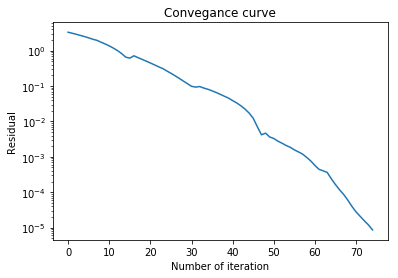

In [16]:
"""

plt.semilogy(residuals)
plt.xlabel('Number of iteration')
plt.ylabel('Residual')
plt.title('Convegance curve')
"""

To format the solution for display purposes, I loop through each node and group the coordinates and nodal value. Interestingly, for float64, the precision is too small to be able to find the point (0.5,0.5). By expanding the range, we can see that both float32 and float64 give values of 0.1308 at (0.5,0.5). The same can be said for the regular and refined mesh. If you want to test this for float64, you will need to use 10000xprecision in the below conditional statement.

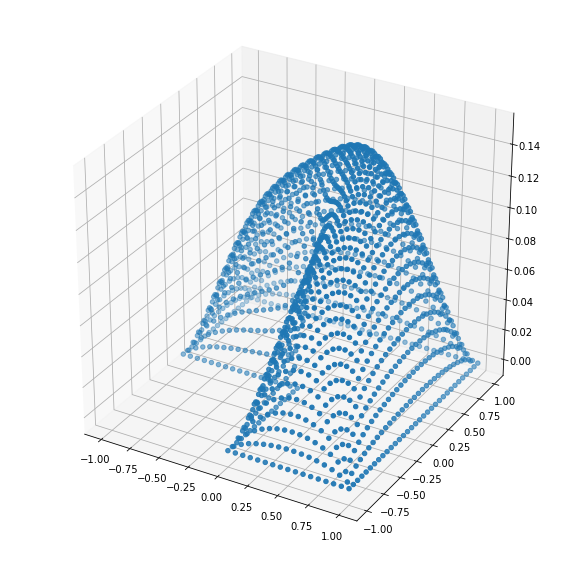

In [17]:

verts = grid.vertices
x=np.zeros(num_vertices)
y=np.zeros(num_vertices)
val=np.zeros(num_vertices)
for i in range(num_vertices):
    x[i]=(verts[i][0])
    y[i]=(verts[i][1])
    val[i]=(solution[i])
    
    if((0.5-precision<x[i]<0.5+precision) and (0.5-precision<y[i]<0.5+precision)):
        print("Solution at the point (0.5,0.5):",val[i])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(x,y,val)



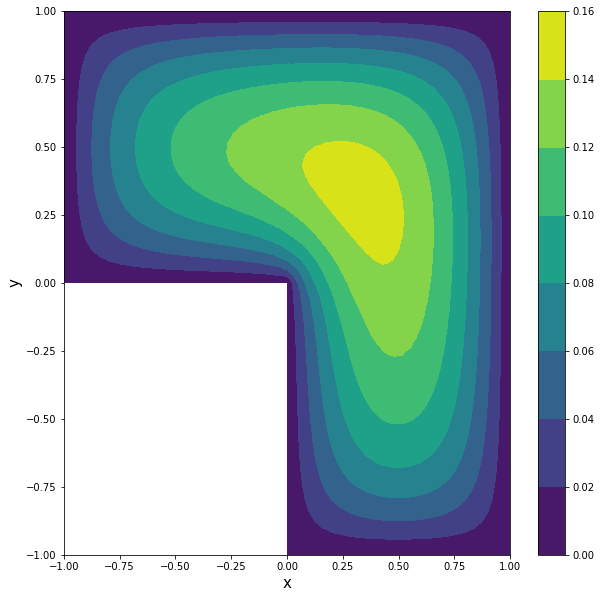

In [18]:
import matplotlib.tri as mtri
%matplotlib inline
triang = mtri.Triangulation(x, y, grid.elements)
plt.figure(figsize=(10, 10))
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.tricontourf(triang, val)
plt.colorbar()

# Part 3

In case you wish to change the values of dtype or lshape.vtk for part 3, you may use the cell below rather than having to scroll all the way to the top.

In [19]:
dtype='float64'
grid = Grid.from_file('lshape.vtk',dtype=dtype)
num_elements = len(grid.elements)
num_vertices = len(grid.vertices)
elements= grid.elements
boundary = test_boundaries(grid)


Corners:

 [[[ 1.       1.       0.     ]
  [ 0.96875  0.96875  0.     ]
  [ 1.       0.9375   0.     ]]

 [[ 0.96875  0.96875  0.     ]
  [ 0.96875  0.90625  0.     ]
  [ 1.       0.9375   0.     ]]

 [[ 0.96875  0.96875  0.     ]
  [ 0.9375   0.9375   0.     ]
  [ 0.96875  0.90625  0.     ]]

 ...

 [[ 0.5625  -0.5      0.     ]
  [ 0.53125 -0.46875  0.     ]
  [ 0.53125 -0.53125  0.     ]]

 [[ 0.5625  -0.5      0.     ]
  [ 0.5625  -0.4375   0.     ]
  [ 0.53125 -0.46875  0.     ]]

 [[ 0.53125 -0.53125  0.     ]
  [ 0.53125 -0.46875  0.     ]
  [ 0.5     -0.5      0.     ]]] 

 Jacobians:

 [[[-0.03125  0.       0.     ]
  [-0.03125 -0.0625   0.     ]
  [ 0.       0.       0.     ]]

 [[ 0.       0.03125  0.     ]
  [-0.0625  -0.03125  0.     ]
  [ 0.       0.       0.     ]]

 [[-0.03125  0.       0.     ]
  [-0.03125 -0.0625   0.     ]
  [ 0.       0.       0.     ]]

 ...

 [[-0.03125 -0.03125  0.     ]
  [ 0.03125 -0.03125  0.     ]
  [ 0.       0.       0.     ]]

 [[ 0.     

We are trying to implement the following

$u_{n+1} = u_{n} - \Delta t M^{-1}Au_{n}$

Recall that the matrix $M_{i}$ for a given element is given by

$M_{nm} = \int \psi_{n}\psi_{m}|det(J_{i})|d\tau$

giving $M_{i}=\frac{1}{24}[[2 1 1],[1 2 1],[1 1 2]]*|det(J)|$, and the local matrix $A_{i}$ is given by

$A^{i}_{nm} = \int J_{i}^{-T}\nabla\psi_{n}.J_{i}^{-T}\nabla\psi_{m}|det(J_{i})|d\tau$ 

The lumped matrix for $M$ on the reference element then simply becomes $\frac{1}{6}[[1 0 0],[0 1 0],[0 0 1]]*|det(J)|$ i.e. a scalar identity.

Inverting this lumped matrix gives

$\frac{6}{|det(J)|}[[1 0 0],[0 1 0],[0 0 1]]$

Notice now that when $M^{-1}$ is applied to $A$, the determinants will cancel, so can be ignored.

As such, the term M^{-1}A simplifies to $\frac{6}{|det(J)|}A$ or a matrix with components

$B^{i}_{nm} = 3*\int J_{i}^{-T}\nabla\psi_{n}.J_{i}^{-T}\nabla\psi_{m}d\tau$ 

The first kernel then aims to calculate locally $\Delta tB^{i}u^{i}_{n}$for each element, while the second assembles the global contributions and and calculate $u_{n+1} = u_{n} - \Delta t Bu_{n}$

In [20]:
 python_time_kernel = """
        
        inline float float_zero()
            {
                return 0.0f;
            }

            inline double double_zero()
            {
                return 0.0;

            }

        __kernel void local_y(const ${realtype} dt,
                                const __global int* elements,
                                    const __global ${realtype} *x,
                                        const __global ${realtype} *jIT,
                                            __global ${realtype} *y_vector
                                        ){
        int gid = get_global_id(0);//element id
        
        //use global to local index map
        int e1 = elements[2*(3*gid)];
        int e2 = elements[2*(3*gid+1)];
        int e3 = elements[2*(3*gid+2)];
        
        //calculate local x vector
        ${realtype} localx[3];
        localx[0] = x[e1];
        localx[1] = x[e2]; 
        localx[2] = x[e3];
        
        //gradient of the hat functions on reference element
        ${realtype} hat1[2] = {-1,-1};

        ${realtype} hat2[2] = {1,0};
        
        ${realtype} hat3[2] = {0,1};
        
        //translate reference element hat functions to grid element basis functions using jacobian inverse transpose
        ${realtype} psi1[2];
        psi1[0] = jIT[9*gid]*hat1[0] + jIT[9*gid+1]*hat1[1];
        psi1[1] = jIT[9*gid+3]*hat1[0] + jIT[9*gid+4]*hat1[1];
        
        
        ${realtype} psi2[2];
        psi2[0] = jIT[9*gid]*hat2[0] + jIT[9*gid+1]*hat2[1];
        psi2[1] = jIT[9*gid+3]*hat2[0] + jIT[9*gid+4]*hat2[1];
       
        
        ${realtype} psi3[2];
        psi3[0] = jIT[9*gid]*hat3[0] + jIT[9*gid+1]*hat3[1];
        psi3[1] = jIT[9*gid+3]*hat3[0] + jIT[9*gid+4]*hat3[1];
        
        
        //Assemble local matrix MA
        
        ${realtype} MA[9];
 
        
        MA[0] = 3*(psi1[0]*psi1[0] + psi1[1]*psi1[1]);
        MA[1] = 3*(psi1[0]*psi2[0] + psi1[1]*psi2[1]);
        MA[2] = 3*(psi1[0]*psi3[0] + psi1[1]*psi3[1]);
        
        MA[3] = 3*(psi2[0]*psi1[0] + psi2[1]*psi1[1]);
        MA[4] = 3*(psi2[0]*psi2[0] + psi2[1]*psi2[1]);
        MA[5] = 3*(psi2[0]*psi3[0] + psi2[1]*psi3[1]);
        
        MA[6] = 3*(psi3[0]*psi1[0] + psi3[1]*psi1[1]);
        MA[7] = 3*(psi3[0]*psi2[0] + psi3[1]*psi2[1]);
        MA[8] = 3*(psi3[0]*psi3[0] + psi3[1]*psi3[1]);


        
        y_vector[3*gid] = dt*(MA[0]*localx[0]+MA[1]*localx[1]+MA[2]*localx[2]);
        y_vector[3*gid+1] = dt*(MA[3]*localx[0]+MA[4]*localx[1]+MA[5]*localx[2]);
        y_vector[3*gid+2] = dt*(MA[6]*localx[0]+MA[7]*localx[1]+MA[8]*localx[2]);
    

        }
        
        __kernel void Time_assembly(const int num_elements,
                                    const __global ${realtype} *y_vector,
                                        const __global int *elements,
                                            const __global ${realtype} *x,
                                            __global ${realtype} *y){
                                            
        int gid = get_global_id(0);

         //if k = one of the element ids for the yi's add the yi's to the overall y for that vertex
         ${realtype} acc = 0;
         for(int k = 0 ; k<num_elements ;k++){
             if((gid)==elements[2*(3*k)]){
                  acc += y_vector[3*k] ;
                  } 
              if((gid)==elements[2*(3*k+1)]){
                  acc += y_vector[3*k+1] ;
                  } 
              if((gid)==elements[2*(3*k+2)]){
                  acc += y_vector[3*k+2] ;
                  }   
          }
          y[gid] = x[gid] - acc;
          
        
        }
"""

In [21]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
ocl_type = {'float32': 'float',
                'float64': 'double'}[dtype]
def time_solve(x,dt):
    #make OpenCl context
    

    #create input buffers

    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements)

    x=(x*boundary).astype(dtype)
    x_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x)



    jacobianInverseTranspose = grid._jacobianInverseTranspose.astype(dtype)
    jacobianInverseTranspose_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                                hostbuf = jacobianInverseTranspose)

    #create output buffer
    y_vector = np.zeros((num_elements,3)).astype(dtype)
    y_vector_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y_vector.nbytes)


    code = Template(python_time_kernel).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    local_y = prg.local_y
    
    if dtype=='float64':
        local_y(queue,(num_elements,),None,np.float64(dt),elements_buffer,x_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
    elif dtype=='float32':
        local_y(queue,(num_elements,),None,np.float32(dt),elements_buffer,x_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
    
    cl.enqueue_copy(queue,y_vector,y_vector_buffer)
    y = time_assembly(x,y_vector)
    return y

def time_assembly(x,y_vector):
    

    code = Template(python_time_kernel).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    assemble_y = prg.Time_assembly

    
    y_vector_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=y_vector)
    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements)
    x_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x)

    y = np.zeros(num_vertices).astype(dtype)
    y_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y.nbytes)
    
    assemble_y(queue,(num_vertices,),None,np.int32(num_elements),y_vector_buffer,elements_buffer,x_buffer,y_buffer)

    cl.enqueue_copy(queue,y,y_buffer)

    y=y*boundary
    return y


You will notice in this version, I am copying back to the host after each timestep. I attempt to solve this in a later version. 

I decide on a number of frames in the animation, a starting distribution for x and a time step $dt$. After solving and saving each frame as an array, I generate the coordinate arrays and animate. I have given 3 starting x vectors: one of random positions, one using the solution from part 2, and one an array full of ones. That last one is the one that is most interesting, and best displays the diffusive nature of the physical system being described.

Let us consider this as describing the cooling of a system. In the first few frames, the points nearest to the boundary (where T=0) drop in temperature the fastest, while points at the center do not change as they are still in thermal equilibrium with the local surroundings. The points in the corners are interesting as they fall in temperature even faster than those at a single edge, showing heat dissipation in both the x and y directions. It is only in the later frames when heat begins to dissipate from the center, after the surroundings have cooled sufficiently. While the initial temperature loss is fast, you can see the rate of cooling slowing down (compare the cooling in the first 100 frames with the 5th 100 frames) showing the exponential decay nature of the temperature.

I've also included a refined mesh via lshapes1.vtk, with an appropriate value for $dt$, for comparison. 

### Please use the correct value of dt for the right refinement of mesh.

The actual animation process can be a little slow, so please allow 1 full minute for it to animate. Feel free to change the number of frame (num_iters) to see the dissipation nature further in time, it is very cool to watch.

In [22]:
num_iters=50
#np.random.seed(1);x=np.random.rand(num_vertices)
#x=solution
x=np.ones(num_vertices)
dt=1/15000 #use with lshape.vtk
#dt=1.0/50000 #use with lshape1.vtk
print("Time Step: ",dt)
sol=np.zeros((num_iters+1,num_vertices))
sol[0]=x*boundary
counter=0
with Timer() as t:
    for i in range(1,num_iters+1):
        counter += 1
        print('Iterations done: {0}'.format(counter), end="\r")

        sol[i]=time_solve(x,dt)
        x=sol[i]
print("Frames computed per second: ",num_iters/t.interval)
verts = grid.vertices
x=[]
y=[]

for i in range(num_vertices):
    x.append(verts[i][0])
    y.append(verts[i][1])

xArray=np.zeros((num_iters+1,len(x)))
                
yArray = np.zeros((num_iters+1,len(y)))
for i in range(num_iters+1):
    xArray[i]=np.array(x)
    yArray[i]=np.array(y)


Time Step:  6.666666666666667e-05
Frames computed per second:  10.55918966082031


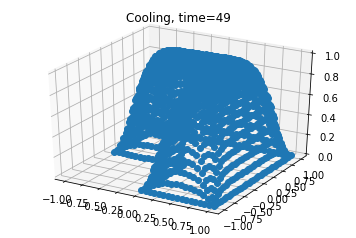

In [23]:
t = np.array([np.ones(num_vertices)*i for i in range(num_iters+1)]).flatten()
df = pd.DataFrame({"time": t ,"x" : xArray.flatten(), "y" : yArray.flatten(), "z" : sol.flatten()})

def update_graph(num):
    data=df[df['time']==num]
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('Cooling, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Cooling')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = animation.FuncAnimation(fig, update_graph, num_iters, 
                               interval=100, blit=True)


HTML(ani.to_html5_video())

Below is where I only copy back to the host after all timesteps are completed. I simply include an extra buffer to store the overall solution, as well as a counter for indexing purposes. The number of frames computed a second is anywhere between 2x - 4x faster! One minor issue is the application of the boundary condition. I'm unaware of any way to apply the boundary condition directly to the buffer, and my attempt to implement the boundary condition within openCL produced incorrect results. As such, I opted to use the simple method of checking if a vertex was part of the first 128, as these are on the boundary. While this is an undesirable solution (and it doesn't work as well with the refined mesh), my aim here was simply to show that not copying to the host would improve speed. Interestingly, the animation for the refined mesh isn't entirely wrong, and does tend towards a similar solution as above; the increase in computation efficiency seems to not be as noticeable.

In [24]:
 python_time_kernel2 = """
        
        __kernel void local_y(const ${realtype} dt,
                                const __global int* elements,
                                    const __global ${realtype} *x,
                                        const __global ${realtype} *jIT,
                                            __global ${realtype} *y_vector
                                                
                                        ){
        int gid = get_global_id(0);//element id
        
        //use global to local index map
        int e1 = elements[2*(3*gid)];
        int e2 = elements[2*(3*gid+1)];
        int e3 = elements[2*(3*gid+2)];
        
        //calculate local x vector
        ${realtype} localx[3];
        localx[0] = x[e1];
        localx[1] = x[e2]; 
        localx[2] = x[e3];
        
        //gradient of the hat functions on reference element
        ${realtype} hat1[2] = {-1,-1};

        ${realtype} hat2[2] = {1,0};
        
        ${realtype} hat3[2] = {0,1};
        
        //translate reference element hat functions to grid element basis functions using jacobian inverse transpose
        ${realtype} psi1[2];
        psi1[0] = jIT[9*gid]*hat1[0] + jIT[9*gid+1]*hat1[1];
        psi1[1] = jIT[9*gid+3]*hat1[0] + jIT[9*gid+4]*hat1[1];
        
        
        ${realtype} psi2[2];
        psi2[0] = jIT[9*gid]*hat2[0] + jIT[9*gid+1]*hat2[1];
        psi2[1] = jIT[9*gid+3]*hat2[0] + jIT[9*gid+4]*hat2[1];
       
        
        ${realtype} psi3[2];
        psi3[0] = jIT[9*gid]*hat3[0] + jIT[9*gid+1]*hat3[1];
        psi3[1] = jIT[9*gid+3]*hat3[0] + jIT[9*gid+4]*hat3[1];
        
        
        //Assemble local matrix MA
        
        ${realtype} MA[9];
 
        
        MA[0] = 3*(psi1[0]*psi1[0] + psi1[1]*psi1[1]);
        MA[1] = 3*(psi1[0]*psi2[0] + psi1[1]*psi2[1]);
        MA[2] = 3*(psi1[0]*psi3[0] + psi1[1]*psi3[1]);
        
        MA[3] = 3*(psi2[0]*psi1[0] + psi2[1]*psi1[1]);
        MA[4] = 3*(psi2[0]*psi2[0] + psi2[1]*psi2[1]);
        MA[5] = 3*(psi2[0]*psi3[0] + psi2[1]*psi3[1]);
        
        MA[6] = 3*(psi3[0]*psi1[0] + psi3[1]*psi1[1]);
        MA[7] = 3*(psi3[0]*psi2[0] + psi3[1]*psi2[1]);
        MA[8] = 3*(psi3[0]*psi3[0] + psi3[1]*psi3[1]);


        
        y_vector[3*gid] = dt*(MA[0]*localx[0]+MA[1]*localx[1]+MA[2]*localx[2]);
        y_vector[3*gid+1] = dt*(MA[3]*localx[0]+MA[4]*localx[1]+MA[5]*localx[2]);
        y_vector[3*gid+2] = dt*(MA[6]*localx[0]+MA[7]*localx[1]+MA[8]*localx[2]);
    

        }
        
        __kernel void Time_assembly(const int num_elements,
                                        const int num_vertices,
                                            const int iteration_counter,
                                                const __global ${realtype} *y_vector,
                                                    const __global int *elements,
                                                            const __global ${realtype} *x,
                                                                __global ${realtype} *y,
                                                                    __global ${realtype} *solution_buffer
                                                    ){
                                            
        int gid = get_global_id(0);

         //if k = one of the element ids for the yi's add the yi's to the overall y for that vertex
         ${realtype} acc = 0;
         if(gid>127){
         
         for(int k = 0 ; k<num_elements ;k++){
             if((gid)==elements[2*(3*k)]){
                  acc += y_vector[3*k] ;
                  } 
              if((gid)==elements[2*(3*k+1)]){
                  acc += y_vector[3*k+1] ;
                  } 
              if((gid)==elements[2*(3*k+2)]){
                  acc += y_vector[3*k+2] ;
                  }   
          }
          y[gid] = x[gid] - acc;
          }else{
          y[gid] = 0;
          }
          solution_buffer[num_vertices*iteration_counter+gid]=y[gid];
        
        }
        
       
"""

In [25]:

ocl_type = {'float32': 'float',
                'float64': 'double'}[dtype]
def time_solve2(x,dt,num_iters):
    #make OpenCl context
    
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    sol = np.zeros((num_iters+1,num_vertices)).astype(dtype)

    sol[0] = x*boundary
    solution_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=sol)
    #create input buffers

    elements_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=elements)
    verts = grid.vertices
    vertices_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=verts)

    x=(x*boundary).astype(dtype)
    x_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=x)

    jacobianInverseTranspose = grid._jacobianInverseTranspose.astype(dtype)
    jacobianInverseTranspose_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                                hostbuf = jacobianInverseTranspose)

    #create output buffer
    y_vector = np.zeros((num_elements,3)).astype(dtype)
    y_vector_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y_vector.nbytes)


    code = Template(python_time_kernel2).render(realtype=ocl_type)
    prg = cl.Program(ctx,code).build()
    local_y = prg.local_y
    
    if dtype=='float64':
        local_y(queue,(num_elements,),None,np.float64(dt),elements_buffer,x_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
    elif dtype=='float32':
        local_y(queue,(num_elements,),None,np.float32(dt),elements_buffer,x_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
    
    assemble_y = prg.Time_assembly


    y = np.zeros(num_vertices).astype(dtype)
    y_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y.nbytes)
    
    assemble_y(queue,(num_vertices,),None,np.int32(num_elements),np.int32(num_vertices),np.int32(1),y_vector_buffer,
               elements_buffer,x_buffer,y_buffer,solution_buffer)

    for i in range(2,num_iters+1):
        cl.enqueue_copy(queue,x_buffer,y_buffer)

        if dtype=='float64':
            local_y(queue,(num_elements,),None,np.float64(dt),elements_buffer,x_buffer,
            jacobianInverseTranspose_buffer,y_vector_buffer)
        elif dtype=='float32':
            local_y(queue,(num_elements,),None,np.float32(dt),elements_buffer,x_buffer,
                jacobianInverseTranspose_buffer,y_vector_buffer)

        assemble_y = prg.Time_assembly


        y = np.zeros(num_vertices).astype(dtype)
        y_buffer = cl.Buffer(ctx, mf.WRITE_ONLY,y.nbytes)

        assemble_y(queue,(num_vertices,),None,np.int32(num_elements),np.int32(num_vertices),np.int32(i),
                   y_vector_buffer,elements_buffer,x_buffer,y_buffer,solution_buffer)
    
    cl.enqueue_copy(queue,sol,solution_buffer)
    return sol


In [26]:
num_iters=50
#np.random.seed(1);x=np.random.rand(num_vertices)
#x=solution
x=np.ones(num_vertices)
dt=1/15000 #use with lshape.vtk
#dt=1.0/50000 #use with lshape1.vtk
print("Time Step: ",dt)

counter=0
with Timer() as t:
    sol=time_solve2(x,dt,num_iters)
print("Frames computed per second: ",num_iters/t.interval)
verts = grid.vertices
x=[]
y=[]

for i in range(num_vertices):
    x.append(verts[i][0])
    y.append(verts[i][1])

xArray=np.zeros((num_iters+1,len(x)))
                
yArray = np.zeros((num_iters+1,len(y)))
for i in range(num_iters+1):
    xArray[i]=np.array(x)
    yArray[i]=np.array(y)


Time Step:  6.666666666666667e-05
Frames computed per second:  34.29588152179601


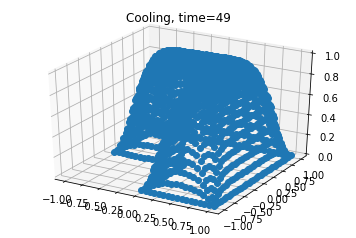

In [27]:
t = np.array([np.ones(num_vertices)*i for i in range(num_iters+1)]).flatten()
df = pd.DataFrame({"time": t ,"x" : xArray.flatten(), "y" : yArray.flatten(), "z" : sol.flatten()})

def update_graph(num):
    data=df[df['time']==num]
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('Cooling, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Cooling')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = animation.FuncAnimation(fig, update_graph, num_iters, 
                               interval=100, blit=True)


HTML(ani.to_html5_video())

I'm quite proud of my work. I think my results look very nice. I just wanted to thank you for putting up with all of my questions, I have learned a lot throughout this course and have really enjoyed it. Thank you.

-Tejan